<a href="https://colab.research.google.com/github/singhmegh/Wildfire-Prediction-Model/blob/main/Wild_fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
# Configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

**Imported** **Wildfire** **Dataset**

In [3]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
 98% 1.42G/1.45G [00:14<00:01, 23.1MB/s]
100% 1.45G/1.45G [00:14<00:00, 108MB/s] 


In [4]:
# extract zip file
from zipfile import ZipFile
dataset = '/content/wildfire-prediction-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [5]:
!ls

kaggle.json  sample_data  test	train  valid  wildfire-prediction-dataset.zip


**Importing** **Libraries**

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from google.colab.patches import cv2_imshow
from PIL import Image,ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

**Create a list**

In [7]:
with_fire = os.listdir('/content/test/wildfire')
print(with_fire[:5])
print(with_fire[-5:])

['-79.1063,46.74221.jpg', '-75.36417,46.74671.jpg', '-66.05611,51.1229.jpg', '-78.32585,53.08004.jpg', '-75.87464,46.78058.jpg']
['-73.80357,45.98142.jpg', '-75.88437,45.88729.jpg', '-73.4715,46.04137.jpg', '-72.76141,46.55396.jpg', '-77.48636,48.76439.jpg']


In [8]:
no_fire = os.listdir('/content/test/nowildfire')
print(no_fire[:5])
print(no_fire[-5:])

['-75.825345,45.34323.jpg', '-79.278867,43.751557.jpg', '-123.175488,49.206439.jpg', '-73.819051,45.557577.jpg', '-79.559708,43.859934.jpg']
['-75.76639,45.374099.jpg', '-75.691287,45.388742.jpg', '-73.46912,45.482276.jpg', '-73.696201,45.531832.jpg', '-75.770153,45.370501.jpg']


In [9]:
print("With_fire",len(with_fire))
print("No_fire",len(no_fire))

With_fire 3480
No_fire 2820


With_fire -> 1

no_fire -> 0

In [10]:
# create the labels

with_fire_labels = [1]*3480
no_fire_labels = [0]*2820

In [11]:
print(with_fire_labels[:5])
print(no_fire_labels[:5])

[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


In [12]:
print(len(with_fire_labels))
print(len(no_fire_labels))

3480
2820


In [13]:
labels = with_fire_labels + no_fire_labels
print(len(labels))
print(labels[:5])
print(labels[-5:])

6300
[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


**Displaying the image with wire or without fire**

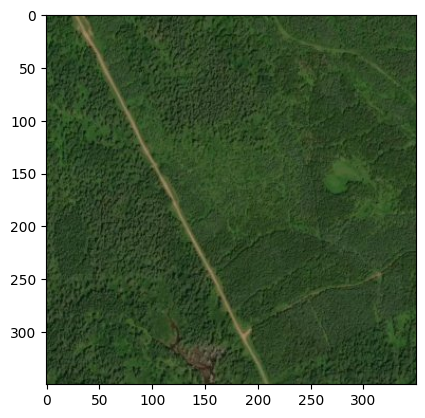

In [14]:
# with fire
img = mpimg.imread('/content/test/wildfire/-64.46741,48.53148.jpg')
img_plot = plt.imshow(img)
plt.show()

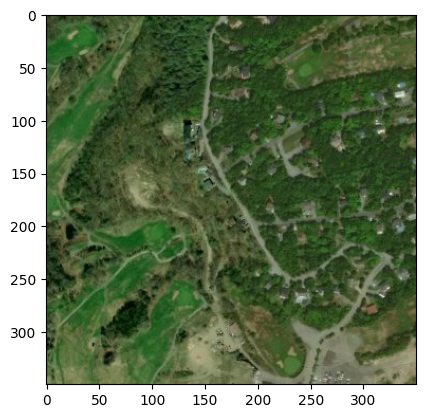

In [15]:
img2 = mpimg.imread('/content/test/wildfire/-71.27798,46.96703.jpg')
imgg_plot = plt.imshow(img2)
plt.show()

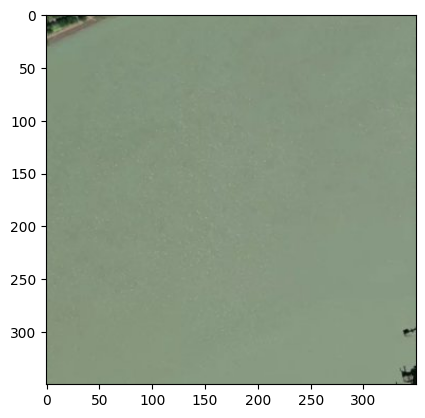

In [16]:
# no_fire

img3 = mpimg.imread('/content/test/nowildfire/-123.03492,49.147113.jpg')
img_plot = plt.imshow(img3)
plt.show()

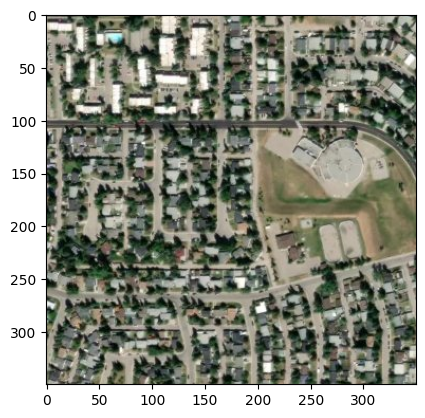

In [17]:
img4 = mpimg.imread('/content/test/nowildfire/-114.080252,50.946889.jpg')
img_plot = plt.imshow(img4)
plt.show()

**Data Cleaning**

In [18]:
# check for coorupted img
def check_images(folder):
    bad_files = []
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)
        try:
            img = Image.open(fpath)
            img.verify()  # check if corrupted
        except:
            bad_files.append(fpath)
    return bad_files

bad_fire = check_images('/content/test/wildfire')
bad_no_fire = check_images('/content/test/nowildfire')

print("Corrupted wildfire images:", bad_fire)
print("Corrupted no-wildfire images:", bad_no_fire)


Corrupted wildfire images: []
Corrupted no-wildfire images: []


In [19]:
import hashlib

In [20]:
# handle duplicated values

def get_hash(image_path):
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def find_duplicates(folder):
    seen = {}
    duplicates = []
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)
        file_hash = get_hash(fpath)
        if file_hash in seen:
            duplicates.append(fpath)
        else:
            seen[file_hash] = fpath
    return duplicates

dup_fire = find_duplicates('/content/test/wildfire')
dup_no_fire = find_duplicates('/content/test/nowildfire')

print("Duplicate wildfire images:", dup_fire)
print("Duplicate no-wildfire images:", dup_no_fire)


Duplicate wildfire images: []
Duplicate no-wildfire images: []


In [21]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [22]:
# standardize the img
img = load_img('/content/test/wildfire/-64.46741,48.53148.jpg', target_size=(224,224))
arr = img_to_array(img)
print(arr.shape)  # should be (224,224,3)


(224, 224, 3)


In [23]:
# normalize the data
arr = arr / 255.0
print(arr)

[[[0.21568628 0.36862746 0.19607843]
  [0.20392157 0.35686275 0.18431373]
  [0.18431373 0.3372549  0.16470589]
  ...
  [0.16862746 0.2627451  0.13725491]
  [0.22352941 0.31764707 0.19215687]
  [0.18039216 0.27450982 0.14901961]]

 [[0.21960784 0.3647059  0.20392157]
  [0.20392157 0.34901962 0.1882353 ]
  [0.21568628 0.36078432 0.2       ]
  ...
  [0.23137255 0.3254902  0.2       ]
  [0.21568628 0.30980393 0.18431373]
  [0.18431373 0.2784314  0.15294118]]

 [[0.16862746 0.3137255  0.15294118]
  [0.13333334 0.2784314  0.11764706]
  [0.16470589 0.3019608  0.14509805]
  ...
  [0.23137255 0.3254902  0.2       ]
  [0.21176471 0.30588236 0.18039216]
  [0.20392157 0.29803923 0.17254902]]

 ...

 [[0.21568628 0.3019608  0.15294118]
  [0.21176471 0.30980393 0.15686275]
  [0.20784314 0.30980393 0.15686275]
  ...
  [0.10588235 0.20784314 0.09411765]
  [0.02745098 0.12941177 0.01568628]
  [0.19607843 0.2901961  0.1882353 ]]

 [[0.1882353  0.28627452 0.13333334]
  [0.18039216 0.28235295 0.12941177]


**Image Preprocessing**

1. Resize the image  

2. Convert the image to numpy array.

In [24]:
from tensorflow.keras.utils import img_to_array

In [25]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

with_fire_path = '/content/test/wildfire/'
no_fire_path = '/content/test/nowildfire/'

with_fire = os.listdir(with_fire_path)
no_fire = os.listdir(no_fire_path)

# Initialize data and labels
data = []
labels = []

# Process wildfire images
for img_file in with_fire:
    try:
        image = Image.open(os.path.join(with_fire_path, img_file))
        image = image.convert('RGB')
        image = image.resize((128, 128))
        image_array = img_to_array(image)
        image_array = image_array / 255.0  # normalize
        data.append(image_array)
        labels.append(1)  # wildfire label
    except OSError:
        print(f"Skipped corrupted image: {img_file}")

# Process no-wildfire images
for img_file in no_fire:
    try:
        image = Image.open(os.path.join(no_fire_path, img_file))
        image = image.convert('RGB')
        image = image.resize((128, 128))
        image_array = img_to_array(image)
        image_array = image_array / 255.0  # normalize
        data.append(image_array)
        labels.append(0)  # no wildfire label
    except OSError:
        print(f"Skipped corrupted image: {img_file}")

# Convert to NumPy arrays
x = np.array(data, dtype='float32')
y = np.array(labels)

del data, labels
import gc; gc.collect()

print("Images shape:", x.shape)
print("Labels shape:", y.shape)


Images shape: (6300, 128, 128, 3)
Labels shape: (6300,)


**Train Test Split**

In [26]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size = 0.2 , random_state = 42)

In [27]:
print(x.shape , x_train.shape , x_test.shape)

(6300, 128, 128, 3) (5040, 128, 128, 3) (1260, 128, 128, 3)


**Data Visualization**

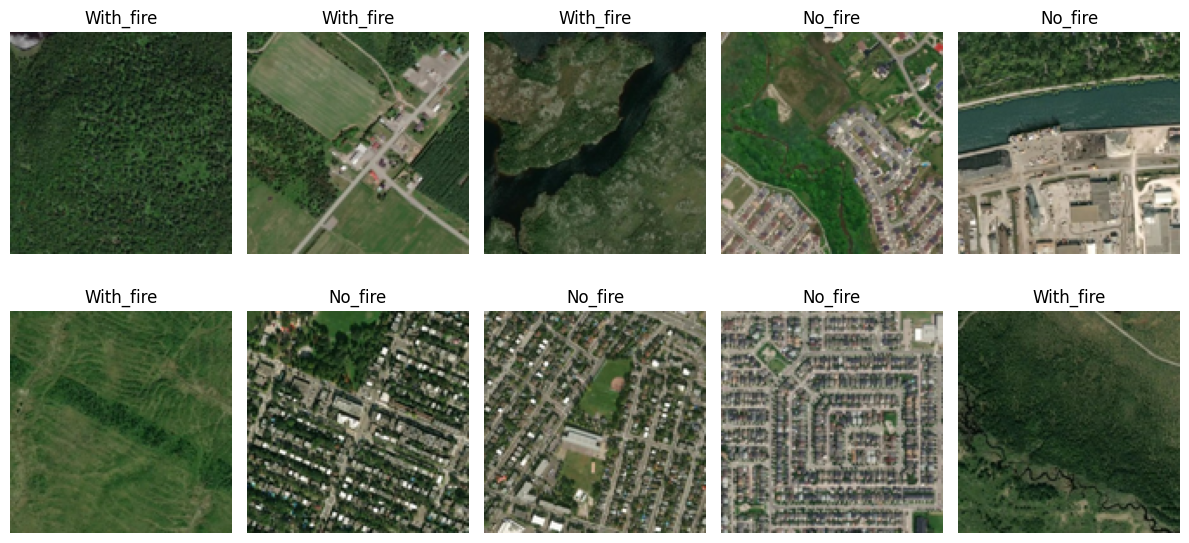

In [28]:
plt.figure(figsize=(12,6))
for i in range(10):
    idx = np.random.randint(0, len(x))
    plt.subplot(2,5,i+1)
    plt.imshow(x[idx])
    plt.title("With_fire" if y[idx]==1 else "No_fire")
    plt.axis("off")
plt.tight_layout()
plt.show()

/tmp/ipython-input-4029066606.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


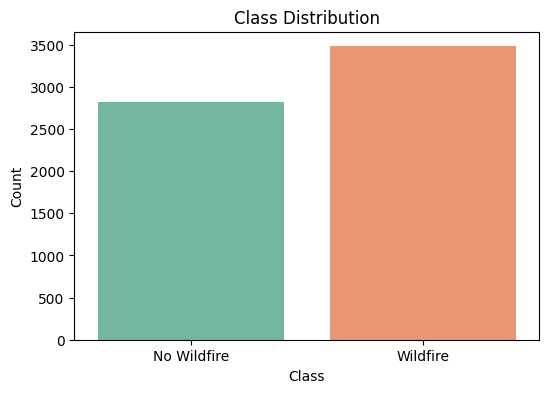

In [29]:
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette="Set2")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0,1], ["No Wildfire", "Wildfire"])
plt.title("Class Distribution")
plt.show()


**Building a Convoltuional Neural Network(CNN)**

In [30]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models

In [31]:
model = keras.Sequential([

    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output
    layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Compile the Neural network**

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

**Model Summary**

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

**Training the Neural Network**

In [34]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [36]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.8911 - loss: 0.2893 - val_accuracy: 0.9222 - val_loss: 0.2257
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9030 - loss: 0.2875 - val_accuracy: 0.8937 - val_loss: 0.2710
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.8931 - loss: 0.3036 - val_accuracy: 0.9056 - val_loss: 0.2447
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8926 - loss: 0.2986 - val_accuracy: 0.9310 - val_loss: 0.2254
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9200 - loss: 0.2439 - val_accuracy: 0.9222 - val_loss: 0.2335


**Model evaluation**

In [37]:
loss , accuracy = model.evaluate(x_test , y_test)
print("Test accuracy=",accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 291ms/step - accuracy: 0.9216 - loss: 0.2362
Test accuracy= 0.9222221970558167


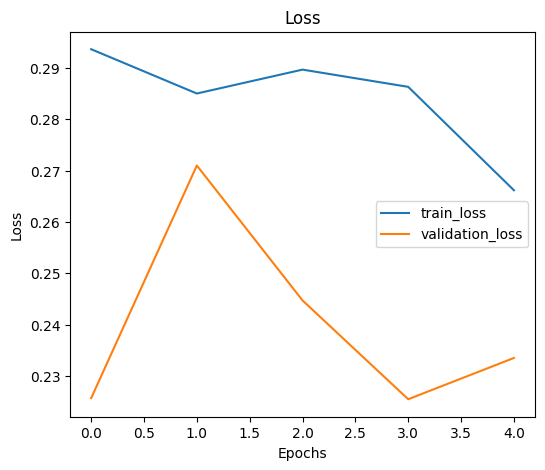

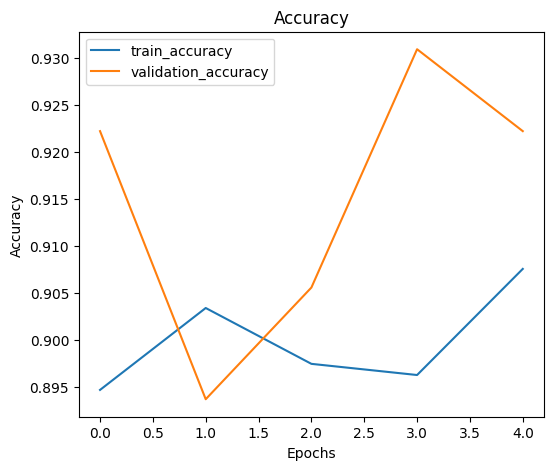

In [49]:
h = history

# Plot the loss value
plt.figure(figsize=(6,5))
plt.plot(h.history['loss'], label='train_loss')
plt.plot(h.history['val_loss'], label='validation_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy value
plt.figure(figsize=(6,5))
plt.plot(h.history['accuracy'], label='train_accuracy')
plt.plot(h.history['val_accuracy'], label='validation_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

**Predictive System**

In [52]:
import cv2

Enter the path of the image: /content/w2.jpeg


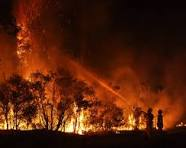

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
[[0.]]
 Wildfire


In [84]:
input_image = input("Enter the path of the image: ")

input_image = cv2.imread(input_image)

cv2_imshow(input_image)

image = cv2.resize(input_image, (128, 128))

image_scaled = image/255

image_reshaped = np.reshape(image_scaled,[1, 128, 128, 3])

input_prediction = model.predict(image_reshaped)

print(input_prediction)

input_pred_label = np.argmax(input_prediction)

if input_pred_label == 0:
  print(" Wildfire")
else:
  print("No Wildfire")

**Pretrained model**

In [77]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [78]:
def resnet(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # freeze weights

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

**Evaluation metrics**

In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("Precision:", precision_score(y_test, y_pred_classes, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_classes, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_classes, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))


40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 292ms/step
Accuracy: 0.44365079365079363
Precision: 0.19682602670697907
Recall: 0.44365079365079363
F1-score: 0.2726781678403449

Classification Report:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61       559
           1       0.00      0.00      0.00       701

    accuracy                           0.44      1260
   macro avg       0.22      0.50      0.31      1260
weighted avg       0.20      0.44      0.27      1260



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m